# Investigation Into The Movie Database (tMBD) Data 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>The Movide Database (tMDB) contains information on thousands of movies dating back to 1960. The key features that will be focussed on within this report include: directors, cast, production companies, revenue and budget (gross and adjusted), popularity and release dates. These features will be investigated to provide insight to some of the following questions:

> 1. How does movie revenue change over time?
>     -  Are movies more profitable in recent years?
> 1. What impact does time of year of a movies release have on its success?
>     -  In what months are the most movies released?
> 1. Who are the most succesful directors, actors and production companies?
>    -  Do same actors, directors and production companies frequently work together?
>    -  Which combinations are most frequent? Which are the most successful?
> 1. What are the most popular movies genres?

>The success of a movie will be measured in terms of movie populrity and the adjusted movie profit.


In [307]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [308]:
df_raw = pd.read_csv('/home/ding/coding/DAND/investigate_dataset_project/movies_dataset/tmdb-movies.csv')
df_raw.head(3)
df_raw.shape
df_raw.duplicated().sum()
df_raw.isnull().sum()
df_raw.nunique()
df_raw.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

**Analysis of the Data Cleanliness**

- There are 10866 rows and 21 columns within that dataset. One of these rows is a duplicate which needs to be deleteted.
- Collumns with null values include: imdb_id, cast, homepage, director, tagline, keywords, overview, genres and production_companies. Since imdb_id, homepage, and overview are not useful for our analysis these columns will be dropped. The keywords column also contains a large amount of null values so will be dropped. We will be using the production_companies column for our analysis later, however, it contains a large amount of null values. To avoid loss of data we will keep rows with null values in this column, then clean it only when we need the feature. This prevents excluding a large number of rows that contain null values in columns that are not being assessed.
- A review of the unique values for each feature indicates that there are 293 non-unique film titles which could be possible duplicates not highlighted in the initial inspection of duplicates.
-  The majority of the data types are appropriate, however the release_date column is current a string in the format dd/mm/yy. To help analysis, we will convert this to the universal yyyy-mm-dd format.


### Data Cleaning

>Now that we have access the strcture and cleanliness of the data we can prepare it for further analysis. Firstly, the columns previously discussed are dropped along with duplicate rows and all null values excluding those found in the production companies column. The release_date column is converted to date_time type.

In [309]:
drop_columns = ['imdb_id','homepage', 'tagline', 'overview', 'keywords']
df_raw.drop(columns=drop_columns, inplace=True)

In [310]:
df_raw.drop_duplicates(inplace=True)
df_raw.dropna(axis=0, subset=['cast', 'director', 'genres'], inplace=True)
df_raw.shape
# confirm only production_companies column has null values
df_raw.isnull().sum() 
df_raw['release_date'] = pd.to_datetime(df_raw['release_date'], dayfirst=True)
df_raw.dtypes

id                               int64
popularity                     float64
budget                           int64
revenue                          int64
original_title                  object
cast                            object
director                        object
runtime                          int64
genres                          object
production_companies            object
release_date            datetime64[ns]
vote_count                       int64
vote_average                   float64
release_year                     int64
budget_adj                     float64
revenue_adj                    float64
dtype: object

### Feature Engineering

> Now that the data has been cleaned we can develop the features within the table. Since most of the analysis involves assessment of the success of the film, it makes sense to add two addition columns, profit and profit_adj to the cleaned DataFrame then write the file as a new csv.

In [311]:
df_raw['profit'] = df_raw.revenue - df_raw.budget
df_raw['profit_adj'] = df_raw.revenue_adj - df_raw.budget_adj
df_raw.head(1)
df_raw.to_csv('/home/ding/coding/DAND/investigate_dataset_project/movies_dataset/df_clean_v1.csv', index=False)

In [312]:
df_clean_v1 = pd.read_csv('/home/ding/coding/DAND/investigate_dataset_project/movies_dataset/df_clean_v1.csv')
df_clean_v1.head(1)

,id,popularity,budget,revenue,original_title,cast,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,profit_adj
0,135397,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015-09-06,5562,6.5,2015,1.379999e+08,1.392446e+09,1363528810,1.254446e+09


>Whilst exploring the dataset further, it became clear that there is a large number of zero values in the budget and revenue columns which skew the data and are most likely to be null values. These rows are removed using the below query and the new dataframe is saved as a new .csv file to be used when analysing movie profits.

In [313]:
df_clean_br = df_clean_v1.query('revenue != 0 and budget != 0')
df_clean_br.to_csv('/home/ding/coding/DAND/investigate_dataset_project/movies_dataset/df_clean_br.csv', index=False)

> Some features have string type values separated by the '|' character. To investigate the most successful actors, production companies and movie genres we need to be able to separate this data out into new rows. The following functions were written to perform this separation and return a block of copied rows, with the values in a specified target column separated. 

In [314]:
def split_row_list(row, row_accumulator, tc, sep):
    ''' (series, list, str, str) -> list
    Data in the target column (tc) of the row series are split according to the separator (sep) and copied with the
    data contained within rows other columns. The new rows are appended to the row_accumulator list which is returned.
    '''
    # Create list of separated values for each row in target columns
    split_list = row[tc].split(sep)
    for s in split_list:
        # Create dict containing all data from row
        new_row = row.to_dict()
        # Set target column value to each element in split_list
        new_row[tc] = s
        # Create list containing new row data
        row_accumulator.append(new_row)
    return row_accumulator


def split_rows(df, tc, sep):
    ''' (DataFrame, str, str) -> DataFrame

    Splits all rows in target column (tc) in DataFrame (df) according to separator (sep).
    Returns a new DafaFrame with all rows in tc split, with all other columns copied.
    '''
    #ensure tc data type is str
    df[tc] = df[tc].astype(str)
    new_rows = []
    df.apply(split_row_list, axis=1, args=(new_rows, tc, sep))
    split_df = pd.DataFrame(new_rows)
    return split_df


> Before using these functions to split the cast, genres and production company rows we need to clean the df_clean_br dataframe further by dropping the null values from the production_companies column.

In [315]:
df_clean_br = pd.read_csv('/home/ding/coding/DAND/investigate_dataset_project/movies_dataset/df_clean_br.csv')
df_clean_br.dropna(axis=0, how='any', inplace=True)
# Check null values are removed
df_clean_br.isnull().sum()

id                      0
popularity              0
budget                  0
revenue                 0
original_title          0
cast                    0
director                0
runtime                 0
genres                  0
production_companies    0
release_date            0
vote_count              0
vote_average            0
release_year            0
budget_adj              0
revenue_adj             0
profit                  0
profit_adj              0
dtype: int64

We can now use these functions to split this data into new rows and save to csv files.

In [316]:
df_split_cast = split_rows(df_clean_br, 'cast', '|')
df_split_cast.head()
df_split_cast.shape

(18979, 18)

In [317]:
df_split_genres = split_rows(df_split_cast, 'genres', '|')
df_split_genres.head()
df_split_genres.shape

(50789, 18)

In [318]:
df_split_prod = split_rows(df_split_genres, 'production_companies', '|')
df_split_prod.head()
df_split_prod.shape

(141865, 18)

In [319]:
df_split_dir = split_rows(df_split_prod, 'director', '|')
df_split_dir.head()
df_split_dir.shape

(152788, 18)

>The process of splitting these values into copied rows has created some more duplicate rows which need to be removed before continuing writing to csv.

In [320]:
dupes = df_split_dir.duplicated()
df_split_dir.query('@dupes == True').count()
dupes.sum()

23

In [321]:
df_split_dir.drop_duplicates(inplace=True)
df_split_dir.shape
df_split_dir.to_csv('/home/ding/coding/DAND/investigate_dataset_project/movies_dataset/df_split_cgp.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis


## How does movie revenue change over time?
 -  Are movies more profitable in recent years?

> In order to assess how movie revenues change over time the data is grouped by release year and the mean movie revenues and budgets are calculated. To help visualise the trends in data, a new variable calculating the 5 year rolling average revenue is created. This variable creates some Null values which are dropped.

> Initially, this analysis was performed on the dataset which included a large amount of zero values. You can see the results below.

In [322]:
df_year = df_clean_v1.groupby('release_year')
counts = df_clean_v1.groupby('release_year')['id'].count()
rev = df_year.revenue.mean()
mv_av = rev.rolling(5).mean()
mv_av.dropna(inplace=True)
budget = df_year.budget.mean()

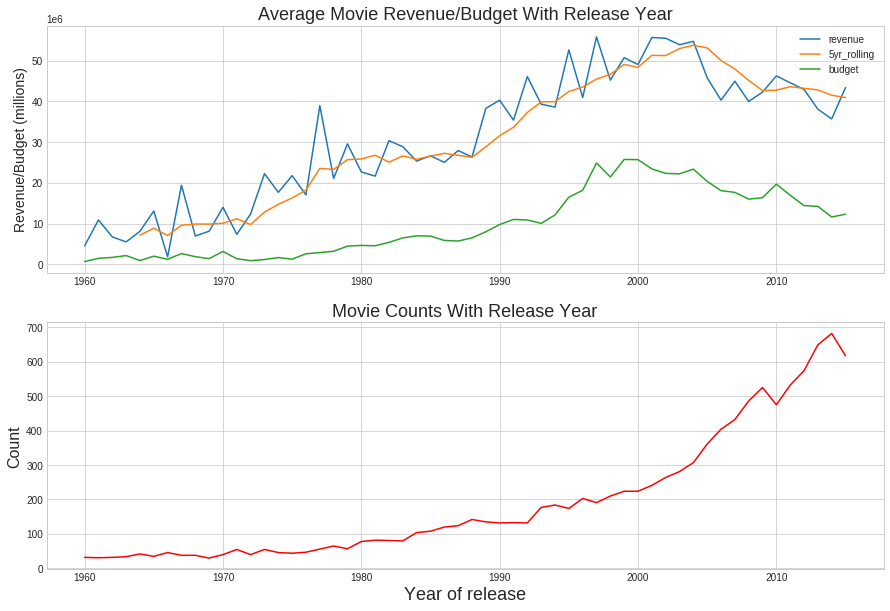

In [323]:
fig = plt.subplots(1,3, figsize=(15,10), sharex=True)

plt.figure(1)
plt.subplot(211)
plt.plot(rev)
plt.plot(mv_av)
plt.plot(budget)
plt.title("Average Movie Revenue/Budget With Release Year", fontsize=18)
plt.ylabel("Revenue/Budget (millions)", fontsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
leg_labels = ['revenue', '5yr_rolling', 'budget']
plt.legend(leg_labels, loc=0);

plt.figure(1)
plt.subplot(212)
plt.plot(counts, 'r')
plt.title("Movie Counts With Release Year", fontsize=18)
plt.xlabel("Year of release", fontsize=18)
plt.ylabel("Count", fontsize=16)

plt.show()

### Initial Deductions

>Average revenue rises and peaks around 2005 where there is a sharp drop in revenues. This coincides very closely with a sharp rise in the number of movies being produced each year as well as a reduction in the average movie budgets. There is a strong correlation between the average movie budget and average revenues.<br>

>**However** from further analysis of the data, we see that there are 7011 rows where the values for budget and/or revenue are zero. It is likely that these zero values actually represent null values, therefore, for sensible analysis of the relationships of revenue and budget over time these values are removed and the analysis is repeated. A distribution of these zero values is represented below.

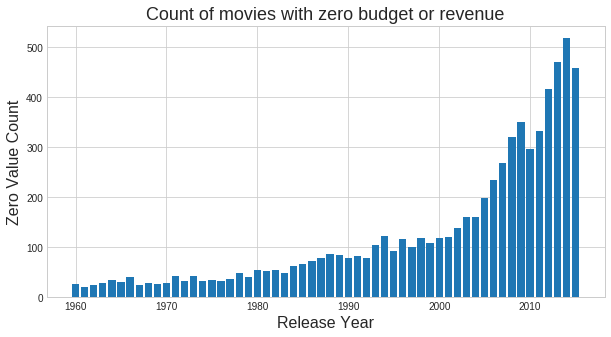

In [324]:
zero_vals = df_clean_v1.query('budget == 0 or revenue == 0')
counts = zero_vals.groupby('release_year')['id'].count()
heights = zero_vals.groupby('release_year').count()['id']
xlabels = counts.index

plt.figure(figsize=(10,5))
plt.bar(xlabels, heights)
plt.xlabel('Release Year', fontsize=16)
plt.ylabel('Zero Value Count', fontsize=16)
plt.title("Count of movies with zero budget or revenue", fontsize=(18))
plt.show()

>This analysis is repeated below using the clean_br dataframe with all zero values removed from the budget and revenue columns.

In [325]:
df_year_v2 = df_clean_br.groupby('release_year')
counts_v2 = df_clean_br.groupby('release_year')['id'].count()
rev_v2 = df_year_v2.revenue.mean()
mv_av_v2 = rev_v2.rolling(5).mean()
mv_av_v2.dropna(inplace=True)
budget_v2 = df_year_v2.budget.mean()

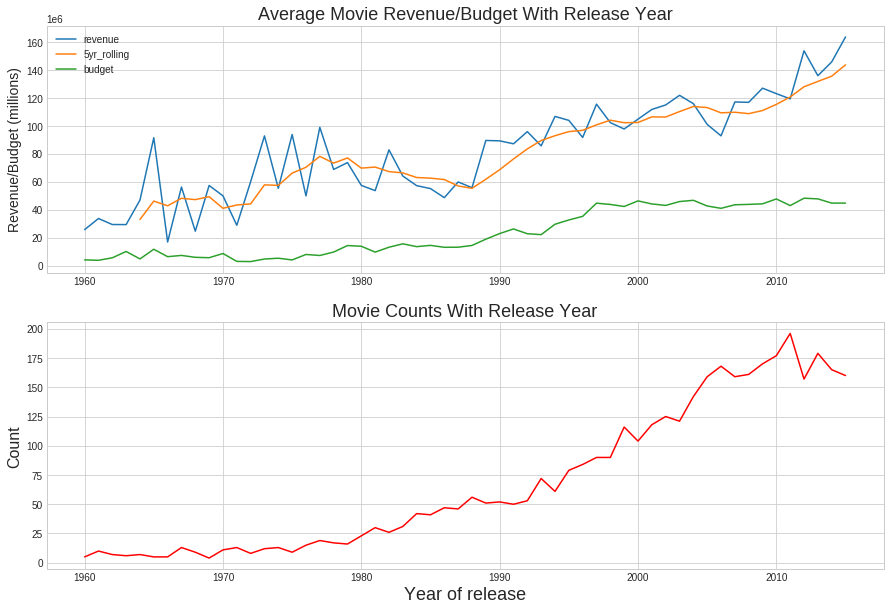

In [326]:
fig = plt.subplots(1,3, figsize=(15,10), sharex=True)

plt.figure(1)
plt.subplot(211)
plt.plot(rev_v2)
plt.plot(mv_av_v2)
plt.plot(budget_v2)
plt.title("Average Movie Revenue/Budget With Release Year", fontsize=18)
plt.ylabel("Revenue/Budget (millions)", fontsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
leg_labels = ['revenue', '5yr_rolling', 'budget']
plt.legend(leg_labels, loc=0);

plt.figure(1)
plt.subplot(212)
plt.plot(counts_v2, 'r')
plt.title("Movie Counts With Release Year", fontsize=18)
plt.xlabel("Year of release", fontsize=18)
plt.ylabel("Count", fontsize=16)

plt.show()

### Deductions

>Now that the zero values for movie budget and revenue has been removed we see a very different trend in the data. There is still a strong correlation between the average movie budget and average revenues, however, we no longer see the average movie revenue and budget fall from 2005. Instead we see the average budget remain stable around 45million and the average revenues rise by around 30million.
>
>We can use this plot to visulaise the average movie profit per year as the gap between the rolling average revenue and the budget plots. We can deduce from this that the most profitable movies we released in the mid to late 1970s, and from 2010 to present day.
>
>It is important to note that this plot uses thes gross values for budget and revenue. The adjusted revenue and budget data takes into account inflation, so to make a true comparison we will repeat the analysis with the adjusted values and check if the same conclusions can be drawn.

> **Do we see this if we plot the adjusted movie budgets and revenues directly?**


In [327]:
rev_year_adj = df_clean_br.groupby('release_year')['revenue_adj'].mean()
mv_av_adj = rev_year_adj.rolling(5).mean()
mv_av_adj.dropna(inplace=True)
av_budg_adj = df_clean_br.groupby('release_year')['budget_adj'].mean()

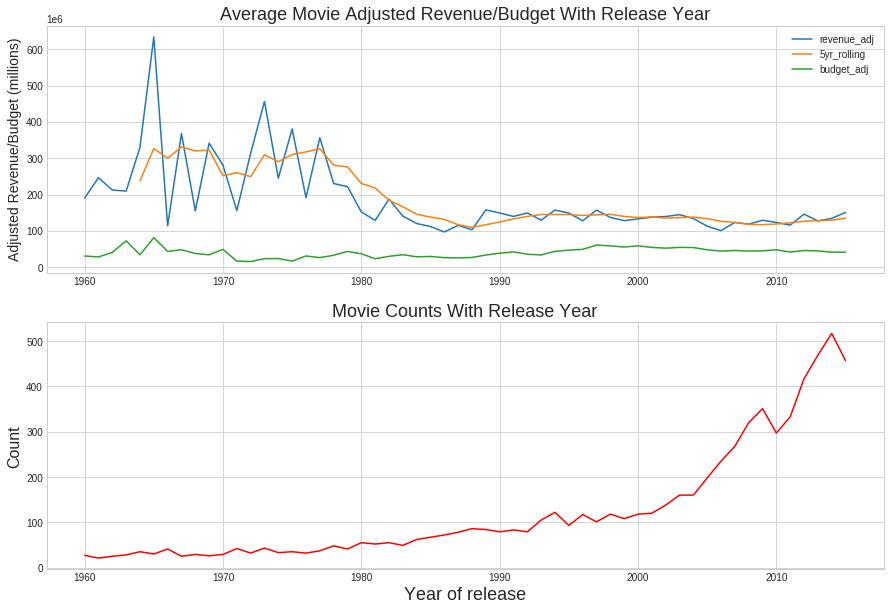

In [328]:
fig = plt.subplots(1,3, figsize=(15,10), sharex=True)

plt.figure(1)
plt.subplot(211)
plt.plot(rev_year_adj)
plt.plot(mv_av_adj)
plt.plot(av_budg_adj)
plt.title("Average Movie Adjusted Revenue/Budget With Release Year", fontsize=18)
plt.ylabel("Adjusted Revenue/Budget (millions)", fontsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
leg_labels = ['revenue_adj', '5yr_rolling', 'budget_adj']
plt.legend(leg_labels, loc=0);

plt.figure(1)
plt.subplot(212)
plt.plot(counts, 'r')
plt.title("Movie Counts With Release Year", fontsize=18)
plt.xlabel("Year of release", fontsize=18)
plt.ylabel("Count", fontsize=16)

plt.show()

### Deductions

>The adjusted revenue and budget plots tell quite a different story. When plotting the adjusted average movie revenues and budget over time we see that the adjusted budget stays relatively stable over time at around 50million, whilst the adjusted revenues have decreased. The major decrease occurred between 1978 and 1988 before stablising around 150million. From this we can draw the conclusion that movies released between 1960 and 1980 were more profitable than movies released since. A possible reason for this could be invreased competition as a result of significantly more movies being released 
>
> As the number of movies being released each year increases, the revenue curve becomes much more stable.

### Further Investigation

>Previously we have see there is a strong correlation between the average movie budget and average revenues. To assess this relationship further we can separate the budget into two categories, High and Low, and assess the revenues of each.
>
>From assessment of the descriptive statistics we can find the median budget value and flag each row as low budget or high budget based from this value. The flags are contained within in a new column called 'bufget_level'. You can see this below.


In [329]:
budget = df_clean_br.budget
revenue = df_clean_br.revenue
bins = [0, 24000000, 425000000]
labels = ['Low', 'High']
df_clean_br['budget_level'] = pd.cut(df_clean_br.budget, bins, labels=labels)
budget.describe() #2.4e7


count    3.805000e+03
mean     3.760800e+07
std      4.232179e+07
min      1.000000e+00
25%      1.000000e+07
50%      2.500000e+07
75%      5.000000e+07
max      4.250000e+08
Name: budget, dtype: float64

>We can use these flags to query the dataframe and create new variables. These variables are plotted against each other in scatter graphs, shown below.

In [330]:
low_budget = df_clean_br.query('budget_level == "Low"')['budget']
low_rev = df_clean_br.query('budget_level == "Low"')['revenue']
high_budget = df_clean_br.query('budget_level == "High"')['budget']
high_rev = df_clean_br.query('budget_level == "High"')['revenue']

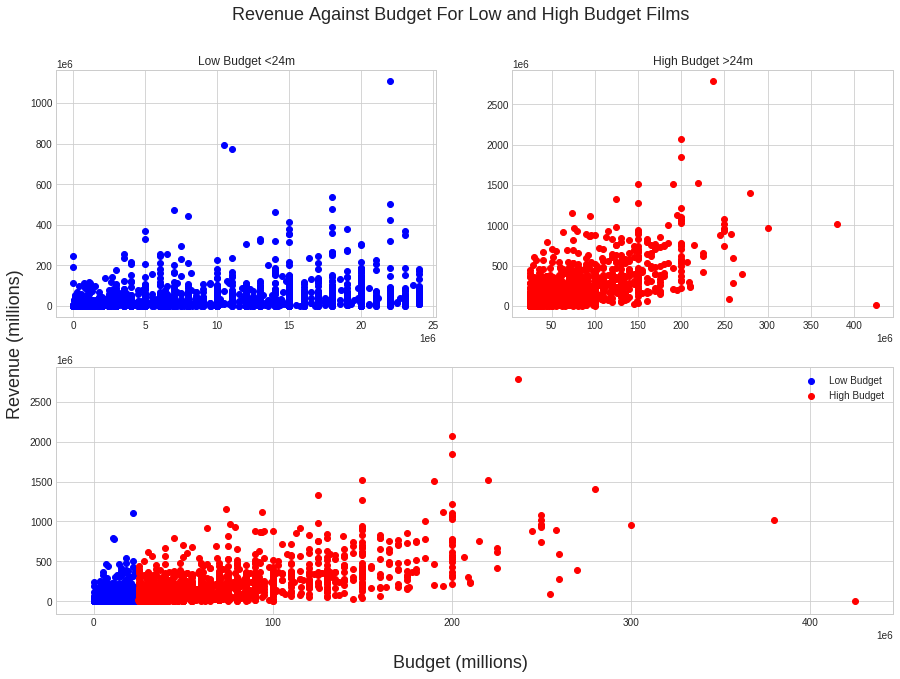

In [332]:
fig, ax = plt.subplots(2,2, figsize=(15,10), sharex=True)

plt.figure(1)
plt.subplot(221)
plt.scatter(x=low_budget, y=low_rev, color='b');
plt.title("Low Budget <24m")
plt.ticklabel_format(axis='x', style='sci', scilimits=(6,6))
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))

plt.figure(1)
plt.subplot(222)
plt.scatter(x=high_budget, y=high_rev, color='r');
plt.title("High Budget >24m")
plt.ticklabel_format(axis='x', style='sci', scilimits=(6,6))
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))

plt.figure(1)
plt.subplot(212)
plt.scatter(x=low_budget, y=low_rev, color='b');
plt.scatter(x=high_budget, y=high_rev, color='r');
plt.ticklabel_format(axis='x', style='sci', scilimits=(6,6))
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
leg_labels = ['Low Budget', 'High Budget']
plt.legend(leg_labels)

fig.text(0.5,0.95,'Revenue Against Budget For Low and High Budget Films', ha='center', fontsize=18)
fig.text(0.08,0.5,'Revenue (millions)', va='center', fontsize=18, rotation='vertical')
fig.text(0.5,0.05,'Budget (millions)', ha='center', fontsize=18)

plt.show()

### Deductions

>There is a positive correlation between the size of the budget and the revenue generated. This correlation is more prevalent for movies with higher budgets.

## What impact does time of year of a movies release have on its success?
-  In what months are the most movies released?

>In order to answer these questions, we first need to group the release dates by month and year quarter. To do this we must first ensure that the column is in datetime format. We can then create new variables for the month and quarterly groupings.
>We will only select the columns related to movie success for each variable. These are: revenue, revenue_adj, budget, budget_adj, profit, profit_adj, popularity

In [333]:
df_clean_br = pd.read_csv('/home/ding/coding/DAND/investigate_dataset_project/movies_dataset/df_clean_br.csv')
df_clean_br['release_date'] = pd.to_datetime(df_clean_br['release_date'], dayfirst=True)
success_columns = ['revenue', 'revenue_adj', 'budget', 'budget_adj', 'popularity', 'profit', 'profit_adj']

months_mean = df_clean_br.groupby(df_clean_br.release_date.dt.month)[success_columns].mean()
months_count = df_clean_br.groupby(df_clean_br.release_date.dt.month)[success_columns].count()['profit']
quarters_mean = df_clean_br.groupby(df_clean_br.release_date.dt.quarter)[success_columns].mean()
quarters_count = df_clean_br.groupby(df_clean_br.release_date.dt.quarter)[success_columns].count()['profit']

>Now that we have our groupings contained within the relevant variables we can visualise the data. It will help to create some lists containing the labels to be used on the x-axis.

In [334]:
labelsQ = ['Q1', 'Q2', 'Q3', 'Q4']
labelsM = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

>Lets first find out which month, and which quarter have seen the most movies releases.

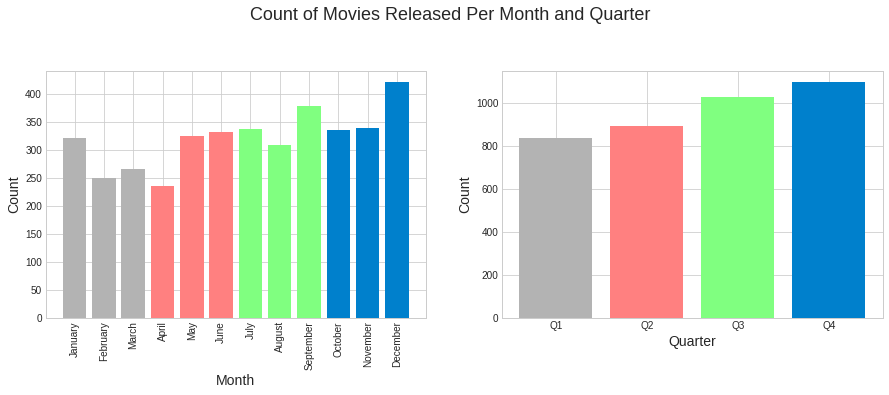

In [335]:
fig, ax = plt.subplots(1,2, figsize=(15,10))

colours = [(0.7,0.7,0.7),(0.7,0.7,0.7),(0.7,0.7,0.7), (1,0.5,0.5),(1,0.5,0.5),(1,0.5,0.5), (0.5,1,0.5),(0.5,1,0.5),(0.5,1,0.5),(0,0.5,0.8),(0,0.5,0.8),(0,0.5,0.8)]
colours2 = [(0.7,0.7,0.7), (1,0.5,0.5), (0.5,1,0.5),(0,0.5,0.8)]

plt.subplot(221)
plt.bar(labelsM, months_count,color=colours)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)

plt.subplot(222)
plt.bar(labelsQ, quarters_count,color=colours2)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Count', fontsize=14)

fig.text(0.5,0.95,'Count of Movies Released Per Month and Quarter', ha='center', fontsize=18)
plt.show()

> -  The month with the lowest total movies releases is April
> -  The month with the highest total movies releases is December
> -  Movie releases increase throughout the year, with Q1 seeing the lowest releases and Q4 the highest

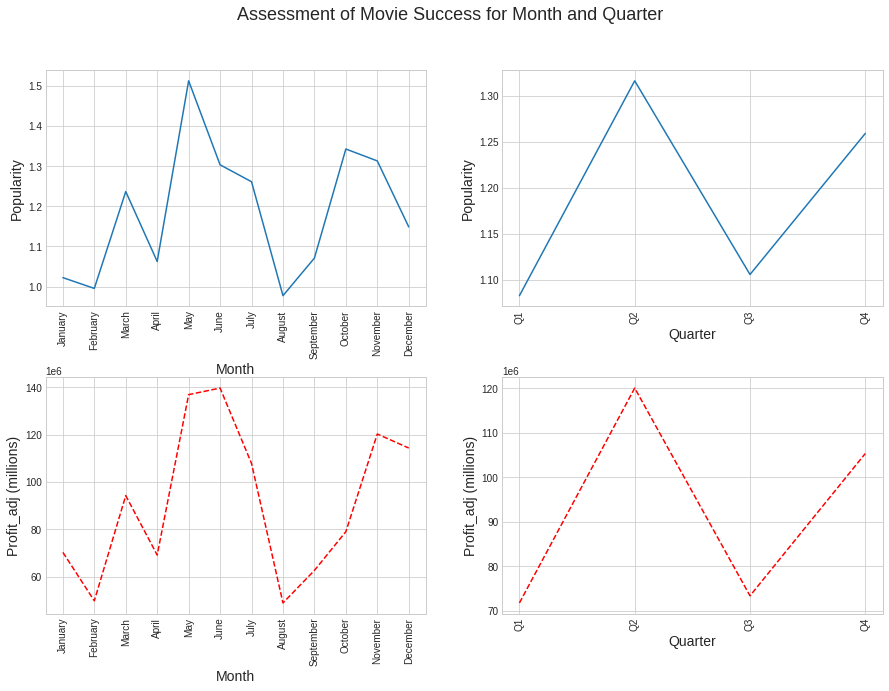

In [336]:
fig, ax = plt.subplots(2,2, figsize=(15,10), sharey=True)
plt.subplots_adjust(hspace=0.3)

plt.subplot(221)
plt.plot(labelsM, months_mean.popularity)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Popularity', fontsize=14)
plt.xticks(rotation=90)

plt.subplot(223)
plt.plot(labelsM, months_mean.profit_adj, 'r--')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Profit_adj (millions)', fontsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
plt.xticks(rotation=90)

plt.subplot(222)
plt.plot(labelsQ, quarters_mean.popularity)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Popularity', fontsize=14)
plt.xticks(rotation=90)

plt.subplot(224)
plt.plot(labelsQ, quarters_mean.profit_adj, 'r--')
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Profit_adj (millions)', fontsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
plt.xticks(rotation=90)

fig.text(0.5,0.95,'Assessment of Movie Success for Month and Quarter', ha='center', fontsize=18)
plt.show()

> -  There is a strong correlation between the popularity of a movie and its adjusted profits.
> -  The most successful movies are generally released in quarters 2 and 4, with May and June seeing the highest success
> -  The least successful movies are generally release in the month of February and August

## Who are the most succesful directors, actors and production companies?
>    -  Do same actors, directors and production companies frequently work together?
>    -  Which combinations are most frequent? Which are the most successful?

>The process of splitting rows creates numerous copies of values in the columns which are not being split, therefore we need to take caution when pulling count values from the dataset. To avoid including duplicate pairings (e.g. the number of times actors and directors have worked together) we must only split these columns for the assessment. Therefore, the df_split_cgp.csv file we wrote earlier with the cast, director, production company and genre columns all split is not appropriate for assessing counts and we need to create new dataframes for each purpose.
>
>The mean averages are unaffected by splitting since the additional counts are factored into the calculation of the average, therefore we can use the df_split_cgp.csv file. It is important to note that this file was created from the df_clean_br.csv file which deleted all rows where budget or revenue contained zero values. 


In [337]:
df_cgp = pd.read_csv('/home/ding/coding/DAND/investigate_dataset_project/movies_dataset/df_split_cgp.csv')
df_clean_v1 = pd.read_csv('/home/ding/coding/DAND/investigate_dataset_project/movies_dataset/df_clean_v1.csv')
df_cgp.shape
df_clean_v1.isnull().sum()

id                        0
popularity                0
budget                    0
revenue                   0
original_title            0
cast                      0
director                  0
runtime                   0
genres                    0
production_companies    959
release_date              0
vote_count                0
vote_average              0
release_year              0
budget_adj                0
revenue_adj               0
profit                    0
profit_adj                0
dtype: int64

>df_cgp contains the data with cast, director, production company and genre columns split. There are no zero values for budget, revenue and profit so we can use this to assess success based on profitability.
>
>df_clean_v1 contains data without any split columns so we will need to split individually based on the count assessments we wish to make. The budget and revenue columns still contain zero values so we cannot use this to assess profitability. Likewise, we need to consider that the production companies column stil has some null values.
>
>Lets start by assessing who has directed the most number of movies. To do this we must first split the director column.
successful directors in terms of adjusted profit and popularity of movies.

In [338]:
dir_split = split_rows(df_clean_v1, 'director', '|')

In [339]:
dir_count = dir_split.groupby(['director']).count().sort_values('id', ascending=False)['id']
print(dir_count.head(10))

director
Woody Allen          46
Clint Eastwood       34
Steven Spielberg     30
Martin Scorsese      30
Steven Soderbergh    23
Ridley Scott         23
Ron Howard           22
Joel Schumacher      21
Brian De Palma       20
Wes Craven           19
Name: id, dtype: int64


>Woody Allen has directed the most films with 46!
>
>Now lets look at who the most successful director is in terms of movie popularity.

In [340]:
# Most popular director
dir_mean = dir_split.groupby(['director']).mean().sort_values('popularity', ascending=False)['popularity']
print('Most Popular Director\n',dir_mean.head(), '\n')

# Most popular director who has directed 5 or more films
dir_count = dir_split.groupby(['director']).count().sort_values('id', ascending=False)
dir_list = (dir_count.query('id >= 5').index)
dir_mean5 = df_cgp.groupby(['director']).mean().sort_values('popularity', ascending=False)
dir_mean5 = dir_mean5.query('director in @dir_list')['popularity']
print('..who has directed 5 or more films\n',dir_mean5.head(), '\n')

Most Popular Director
 director
Colin Trevorrow    16.696886
Chad Stahelski     11.422751
David Leitch       11.422751
Juno John Lee       8.411577
Alan Taylor         6.883129
Name: popularity, dtype: float64 

..who has directed 5 or more films
 director
Christopher Nolan                 8.868921
Alejandro GonzÃ¡lez IÃ±Ã¡rritu    6.253197
Kyle Balda                        5.497033
David Yates                       5.106886
J.J. Abrams                       4.719866
Name: popularity, dtype: float64 



>Colin Trevorrow is the most successful director in terms of average movie popularity. Christopher Nolan is the most successful in terms of popularity for directors who have directed 5 or more films.
>
>Now lets see which are the most successful actors. To do this we must now split the cast column too.

In [341]:
cast_split = split_rows(dir_split, 'cast', '|')

In [342]:
actor_mean_pop = cast_split.groupby(['cast']).mean().sort_values('popularity', ascending=False)['popularity']
print('Highest Average Popularity Actor\n',actor_mean_pop.head(), '\n')

actor_count = cast_split.groupby(['cast']).count().sort_values('popularity', ascending=False)
actor_count = actor_count.query('id >= 5')
actor_list = list(actor_count.index)
actor_mean_pop5 = cast_split.groupby(['cast']).mean().sort_values('popularity', ascending=False)
actor_mean_pop5 = actor_mean_pop5.query('@actor_mean_pop5.index in @actor_list')['popularity']
print('..who has appeared in 5 or more films\n',actor_mean_pop5.head(), '\n')


Highest Average Popularity Actor
 cast
Josh Helman         28.419936
Daisy Ridley        11.173104
Hugh Keays-Byrne    10.211471
Daniel Henney        8.691294
Ryan Potter          8.691294
Name: popularity, dtype: float64 

..who has appeared in 5 or more films
 cast
Nick Robinson          6.882972
Theo James             6.820448
Bryce Dallas Howard    5.876791
Chris Pratt            5.594719
Irrfan Khan            5.331042
Name: popularity, dtype: float64 



>Josh Helman has the highest average popularity for movies that he has appeared in, whilst Nick Robinson has the highest average popularity for those who have appeared in more than 5 films.
>
>Lets look into actor success by movie profits

In [343]:
actor_mean_prof = cast_split.groupby(['cast']).mean().sort_values('profit_adj', ascending=False)['profit_adj']
print('Highest Average Profit Actor\n',actor_mean_prof.head(), '\n')

actor_mean_prof5 = cast_split.groupby(['cast']).mean().sort_values('profit_adj', ascending=False)
actor_mean_prof5 = actor_mean_prof5.query('@actor_mean_prof5.index in @actor_list')['profit_adj']
print('..who has appeared in 5 or more films\n',actor_mean_prof5.head(), '\n')

Highest Average Profit Actor
 cast
Robert MacNaughton    1.767968e+09
Daisy Ridley          1.718723e+09
Ben Wright            1.545635e+09
J. Pat O'Malley       1.545635e+09
Betty Lou Gerson      1.545635e+09
Name: profit_adj, dtype: float64 

..who has appeared in 5 or more films
 cast
Rod Taylor            7.824618e+08
Murray Hamilton       6.382232e+08
Carrie Fisher         5.592832e+08
Alec Guinness         5.518811e+08
Billy Dee Williams    5.165391e+08
Name: profit_adj, dtype: float64 



>Now lets see which are the most common Actor-Director partnerships.

In [344]:
da_count = cast_split.groupby(['director', 'cast']).count().sort_values('popularity', ascending=False)['id']
da_count.head(10)

director         cast            
Woody Allen      Woody Allen         28
Clint Eastwood   Clint Eastwood      22
Tyler Perry      Tyler Perry         14
Woody Allen      Mia Farrow          12
Gerald Thomas    Kenneth Williams    11
                 Charles Hawtrey     10
                 Sid James           10
Martin Scorsese  Robert De Niro       9
Gerald Thomas    Joan Sims            9
Dennis Dugan     Adam Sandler         8
Name: id, dtype: int64

>Woody Allen, Clint Eastwood and Tyler Perry have all cast themselves numerous times to form the top 3. The most frequent actor-director partnership excluding self casting is Woody Allen and Mia Farrow.
>
>Now lets look at the most successful pairing in terms of popularity.

In [345]:
da_pop = cast_split.groupby(['director', 'cast']).mean().sort_values('popularity', ascending=False)['popularity']
da_pop.head(10)

director           cast               
Colin Trevorrow    Nick Robinson          32.985763
                   Bryce Dallas Howard    32.985763
                   Chris Pratt            32.985763
                   Vincent D'Onofrio      32.985763
                   Irrfan Khan            32.985763
George Miller      Josh Helman            28.419936
                   Tom Hardy              28.419936
                   Charlize Theron        28.419936
                   Nicholas Hoult         28.419936
Christopher Nolan  Casey Affleck          24.949134
Name: popularity, dtype: float64

>Colin Trevorrow again has the highest average popularity when paired with 5 other actors. Sinces the averages with all 5 pairs are equal we could assume that this all stems from a single film. It would be interesting to assess the popularity of actors and directors who have worked together 5 times or more.
>
>To do this we can query the dataframe to generate a list of pairs then filter on this list.

In [346]:
# Create new df to be queried on counts
da_pair5 = cast_split.groupby(['director', 'cast']).count().sort_values('popularity', ascending=False)
da_pair5 = da_pair5.query('id >= 5')
# Generate pairs list
da_pair_list = list(da_pair5.index)
# Create new df to be queried on means
da_pop5 = cast_split.groupby(['director', 'cast']).mean().sort_values('popularity', ascending=False)
da_pop5 = da_pop5.query('@da_pop5.index == @da_pair_list')['popularity']
print(da_pop5.head(10), '\n')
# print(da_pop5.tail(10))

director            cast                
Christopher Nolan   Michael Caine           9.598000
Peter Jackson       Ian McKellen            7.082911
Gore Verbinski      Johnny Depp             3.749814
Tim Burton          Helena Bonham Carter    2.662820
Martin Scorsese     Leonardo DiCaprio       2.436525
Tim Burton          Johnny Depp             2.420913
Guillermo del Toro  Ron Perlman             2.251749
Ridley Scott        Russell Crowe           2.097328
Sylvester Stallone  Sylvester Stallone      1.542367
Frank Coraci        Adam Sandler            1.435779
Name: popularity, dtype: float64 



>Christopher Nolan and Michael Caine are the most popular pairing to have worked together 5 times or more.
>
>Now lets look into the profitability of these assessments, and  investigate the most successful production companies. Since we are looking at profits we need to use the df_cgp dataframe which has excluded the zero values in budget and revenue.
>
>Lets start with the most profitable director. As above we will assess this for all directors, then those who have directed 5 films or more.

In [347]:
# Find the most profitable director.
dir_mean = df_cgp.groupby(['director']).mean().sort_values('profit_adj', ascending=False)['profit_adj']
print('Highest Average Profit Director\n',dir_mean.head(), '\n')

# Find the most profitable director who has directed 5 or more films.
# dir_count = dir_split.groupby(['director']).count().sort_values('id', ascending=False)
# dir_list = (dir_count.query('id >= 5').index)
dir_mean5 = df_cgp.groupby(['director']).mean().sort_values('profit_adj', ascending=False)
dir_mean5 = dir_mean5.query('director in @dir_list')['profit_adj']
print('..who has directed 5 or more films\n',dir_mean5.head(), '\n')

Highest Average Profit Director
 director
Irwin Winkler       1.551568e+09
Clyde Geronimi      1.545635e+09
Hamilton Luske      1.545635e+09
Richard Marquand    1.182995e+09
Jennifer Lee        1.052306e+09
Name: profit_adj, dtype: float64 

..who has directed 5 or more films
 director
Irwin Winkler    1.551568e+09
George Lucas     9.486375e+08
James Cameron    8.824269e+08
David Yates      8.690269e+08
Kyle Balda       7.523504e+08
Name: profit_adj, dtype: float64 



>Irwin Winkler has the highest adjusted profit of all directors, including those who have directed 5 films or more.
>
>Lets repeat this process to find the most profitable actor - director pairings.

In [348]:
da_mean = df_cgp.groupby(['director', 'cast']).mean().sort_values('profit_adj', ascending=False)['profit_adj']
print('Most Profitable Pair\n',da_mean.head(), '\n')

da_mean5 = df_cgp.groupby(['director', 'cast']).mean().sort_values('profit_adj', ascending=False)
da_mean5 = da_mean5.query('@da_mean5.index == @da_pair_list')['profit_adj']
print('..who have worked together 5 or more times \n',da_mean5.head(), '\n')

Most Profitable Pair
 director      cast         
George Lucas  Carrie Fisher    2.750137e+09
              Alec Guinness    2.750137e+09
              Peter Cushing    2.750137e+09
              Mark Hamill      2.750137e+09
              Harrison Ford    2.750137e+09
Name: profit_adj, dtype: float64 

..who have worked together 5 or more times 
 director           cast            
Peter Jackson      Ian McKellen        8.700162e+08
Mike Thurmeier     Chris Wedge         7.429325e+08
Christopher Nolan  Michael Caine       5.350659e+08
Gore Verbinski     Johnny Depp         2.922370e+08
Garry Marshall     HÃ©ctor Elizondo    2.872840e+08
Name: profit_adj, dtype: float64 



>George Lucas and 5 of the cast from Star Wars are the most profitbale pairings of all time.
>
>Peter Jackson and Ian McKellen are the successful pair in terms of profit who have worked together 5 times or more.
>
>Finally, we will investigate the production companies to see which companies have produced the most movies and which are the most and least successful in terms of profitability and movie popularity.
>
>To find out which company has produced the most movies we can use the df_clean.v1.csv file, remove the null values and split the porcuction companies column. 

In [349]:
df_prod_prof = pd.read_csv('/home/ding/coding/DAND/investigate_dataset_project/movies_dataset/df_split_cgp.csv')
df_prod = pd.read_csv('/home/ding/coding/DAND/investigate_dataset_project/movies_dataset/df_clean_v1.csv')
df_prod.dropna(inplace=True)
prod_split = split_rows(df_prod, 'production_companies', '|')

In [350]:
movie_count = prod_split.groupby('production_companies').count().sort_values('id', ascending=False)['id']
print(movie_count.head(10))

production_companies
Universal Pictures                        522
Warner Bros.                              509
Paramount Pictures                        431
Twentieth Century Fox Film Corporation    282
Columbia Pictures                         272
New Line Cinema                           219
Metro-Goldwyn-Mayer (MGM)                 218
Walt Disney Pictures                      213
Touchstone Pictures                       178
Columbia Pictures Corporation             160
Name: id, dtype: int64


>Universal Picture have directed the most movies with 522.
>
>Lets now look at the average movie popularity

In [351]:
movie_pop = prod_split.groupby('production_companies').mean().sort_values('popularity', ascending=False)['popularity']
print(movie_pop.head(10))

production_companies
Bulletproof Cupid          14.311205
Fuji Television Network    12.777401
DefyNite Films             11.422751
Truenorth Productions      11.173104
3Foot7                     10.174599
Linson Films                8.947905
Atman Entertainment         8.947905
Bristol Automotive          8.110711
Dayday Films                7.137273
Syncopy                     7.050715
Name: popularity, dtype: float64


>Bulleproof Cupid have on average produced the most popular movies
>
>Lets now look at the average movie profitability.

In [352]:
movie_prof = df_prod_prof.groupby('production_companies').mean().sort_values('profit_adj', ascending=False)['profit_adj']
print('Higest Average Profit', movie_prof.head(10), '\n')
print('Lowest Average Profit', movie_prof.tail(5), '\n')

Higest Average Profit production_companies
Hoya Productions                                   2.128036e+09
Truenorth Productions                              1.718723e+09
Alfran Productions                                 1.246626e+09
Argyle Enterprises                                 1.072786e+09
EMI Films                                          1.021009e+09
Julia Phillips and Michael Phillips Productions    1.021009e+09
MIRACLE Productions GmbH & Co. KG                  9.415495e+08
Disney Enterprises                                 9.134635e+08
Lucasfilm                                          8.752207e+08
The Saul Zaentz Company                            8.447417e+08
Name: profit_adj, dtype: float64 

Lowest Average Profit production_companies
Le Studio Canal+                 -8.758214e+07
Screenland Pictures              -9.518961e+07
Silver Bullet Productions (II)   -1.551102e+08
Blind Wink Productions           -1.551102e+08
Boram Entertainment Inc.         -4.139124e+08
Name

>Hoya Productions have produced on average the most profitable movies, with an average profit of 212 million. Interestingly, none of the top 10 most popular production companies feature in the top 10 most profitable production companies.
>
>Boram Entertainment are the least successful in terms of average profit, with an average loss of 41 million!
>
>Finally, we'll look at total movie profit and losses.

In [353]:
total_prof = df_prod_prof.groupby('production_companies').sum().sort_values('profit_adj', ascending=False)['profit_adj']
print('Higest Total Profit', total_prof.head(10), '\n')
print('Lowest Total Profit', total_prof.tail(10), '\n')

Higest Total Profit production_companies
Warner Bros.                              7.176939e+11
Walt Disney Pictures                      6.448358e+11
Universal Pictures                        6.388741e+11
Twentieth Century Fox Film Corporation    6.137566e+11
Paramount Pictures                        5.463493e+11
DreamWorks Animation                      3.291430e+11
Columbia Pictures                         3.127448e+11
Amblin Entertainment                      2.782094e+11
DreamWorks SKG                            2.647691e+11
Pixar Animation Studios                   2.348125e+11
Name: profit_adj, dtype: float64 

Lowest Total Profit production_companies
David Kirschner Productions   -2.382505e+09
Warner Bros. Pictures         -2.482464e+09
Dante Entertainment           -2.563322e+09
Big Talk Productions          -2.834247e+09
Square USA                    -3.193752e+09
Weinstein Company, The        -3.422715e+09
Chris Lee Productions         -3.452800e+09
Yer Dead Productions     

>Warner Bros. are the most profitable production company of all time, with adjusted profits totalling 71.7 billion (1000 millions).
>
>Boram Entertainment Inc. are the least profitable production company, with losses totalling 10.3 billion.

## What are the most successful movie genres?

>To answer this question we can use the df_split_cgp.csv file as we will only be dealing with averages and not counts. We can create a simple plot using a groupby statement on genres and plotting the average popularity and adjusted profits.

In [354]:
df_cgp = pd.read_csv('/home/ding/coding/DAND/investigate_dataset_project/movies_dataset/df_split_cgp.csv')

In [355]:
genres = df_cgp.groupby('genres')[success_columns].mean()
genre_labels = list(genres.index)

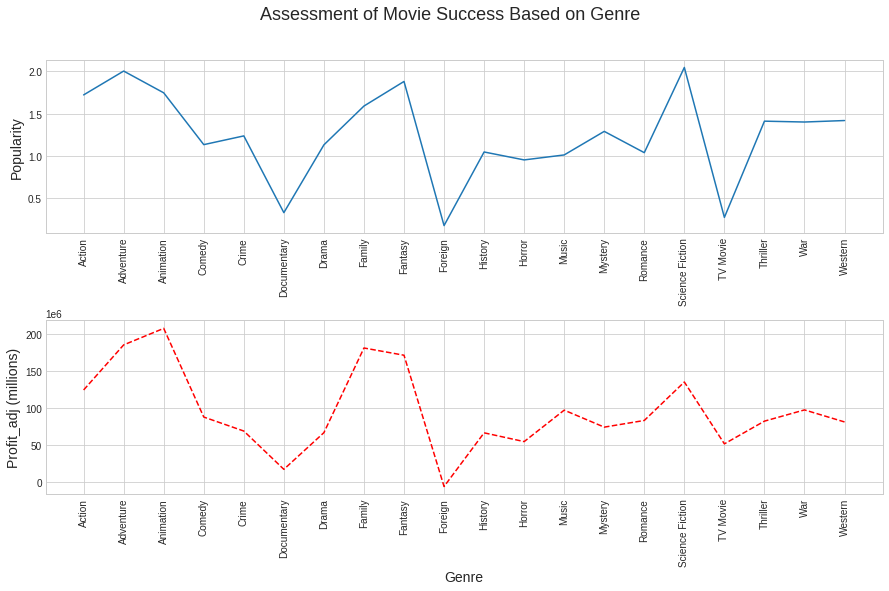

In [356]:
fig, ax = plt.subplots(2,2, figsize=(15,8), sharex=True)
plt.subplots_adjust(hspace=0.5)

plt.subplot(211)
plt.plot(genres.popularity)
plt.ylabel('Popularity', fontsize=14)
plt.xticks(rotation=90)

plt.subplot(212)
plt.plot(genres.profit_adj, 'r--')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Profit_adj (millions)', fontsize=14)
plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
plt.xticks(rotation=90)

fig.text(0.5,0.95,'Assessment of Movie Success Based on Genre', ha='center', fontsize=18)
plt.show()

### Deductions
> - There is a strong correlation between movie popularity and profitability. In general, if a genre is popular then it is also profitable, with some exceptions described below.
> - Science fiction is the most popular movie genre, however it is the 5th most profitable. A possible explanation for this could be increased production costs that are required for filming.
> - Animation is the 4th most popular genre but it is also the most proftibale. Perhaps this could be to do with reduced production costs.
> - Documentaries, foreign anf TV Movies all perform poorly in both popularity and profitability.

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!

>This report has investigated a great deal of trends within the movie database. The key findings and limitations associated with these are summarised below:

> 1. How does movie revenue change over time?
>     -  Are movies more profitable in recent years?
> 1. What impact does time of year of a movies release have on its success?
>     -  In what months are the most movies released?
> 1. Who are the most succesful directors, actors and production companies?
>    -  Do same actors, directors and production companies frequently work together?
>    -  Which combinations are most frequent? Which are the most successful?
> 1. What are the most popular movies genres?



> 1. How does movie revenue change over time?
   - The gross average gross profits of years has generally increased year on year. There is a strong correlation between the average movie budget and the average revenue.
   - The most profitable movies were released between the years 1960 - 1980. This is based on the adjusted budget an revenue columns. In order to assess the validity of this statement we should inspect the calculation and include a buffer to account error in the calculation.
> 1. What impact does time of year of a movies release have on its success?
   - The time of year of a movie release appears to have a significant impact on the movies popularity and profitability. The most movies are released in quarter 4, with the highest month being December.
   - The most successful movies in terms of both popularity and profitability are released in quarters 2 and 4, with the most successful months being May, June and November.
   - These assessments are based on the adjusted profits and the popularity being the key measures of success. As previously discussed, there is possible error with the adjusted profits which should be considered. Data not included in this database which would help measure success would be the number of awards and award nominations for each film.
> 1. Who are the most succesful directors, actors and production companies?
   - The **director** who has directed the most movies is Woody Allen with 46
   - The **director** with highest average popularity is Colin Trevorrow. Christopher Nolan has the highest average popularity for those who have directed 5 or more films.
   - The **director** with highest average profit is Irwin Winkler including all directors and those who have directed 5 or more films.
   - The most successful **actor director partnerships** in terms of movie popularity are Colin Trevorrow paired with a cast of 5 people, and Christopher Nolan and Michael Caine for pairs who have worked together 5 times or more.
   - The most successful **actor director partnerships** in terms of average movie profit are George Lucas paired with a cast of 5 people, and Peter Jackson paired with Ian McKellen for pairs who have worked together 5 times or more.
   - The **production company** which has produced the most films is Universal Pictures with 55.
   - The **production company** which has produced movies with the highest average popularity is Bulletproof Cupid.
   - The **production company** with highest average profit is Hoya Productions with an average of 212 million.
   - The **production company** with highest total profit is Warner Bros. with adjusted profits totalling 71.7 billion (1000 millions).
   - The **production company** with the worst average and total profits is Boram Entertainment Inc. with an average loss of 41 million and a total loss of 10.3 billion.
   - The biggest
> 1. What are the most popular movies genres?
   - The most popular movie genres are science fiction, adventure and fantasy respectively.
   - The most profitable movie genres are animation,adventure and family respectively.
>**The biggest limitation associated with these conclusions are that the currency of budget and revenue is unknown. Therefore, we can only assume that the currency is consistent throughout, if it is not then currency exchange rates could change every conclusion which is based on these variables.**
